# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

In [1]:
# standard library imports
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
# loading dataset
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

In [3]:
# create training set, validation set and test set.
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [5]:
# Explore dataset through dataset_info
num_training_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples
num_classes = dataset_info.features['label'].num_classes

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Test Images: {} \n'.format(num_test_examples))
print('Total Number of Classes: {}'.format(num_classes))

Total Number of Training Images: 1020
Total Number of Validation Images: 1020
Total Number of Test Images: 6149 

Total Number of Classes: 102


In [6]:
# print  shape & corresponding label of three images from training set
i = 1
for example in training_set.take(3):
    print('Image %s shape: %s label: %s'%(i, example[0].shape, example[1]))
    i += 1

Image 1 shape: (500, 667, 3) label: tf.Tensor(72, shape=(), dtype=int64)
Image 2 shape: (500, 666, 3) label: tf.Tensor(84, shape=(), dtype=int64)
Image 3 shape: (670, 500, 3) label: tf.Tensor(70, shape=(), dtype=int64)


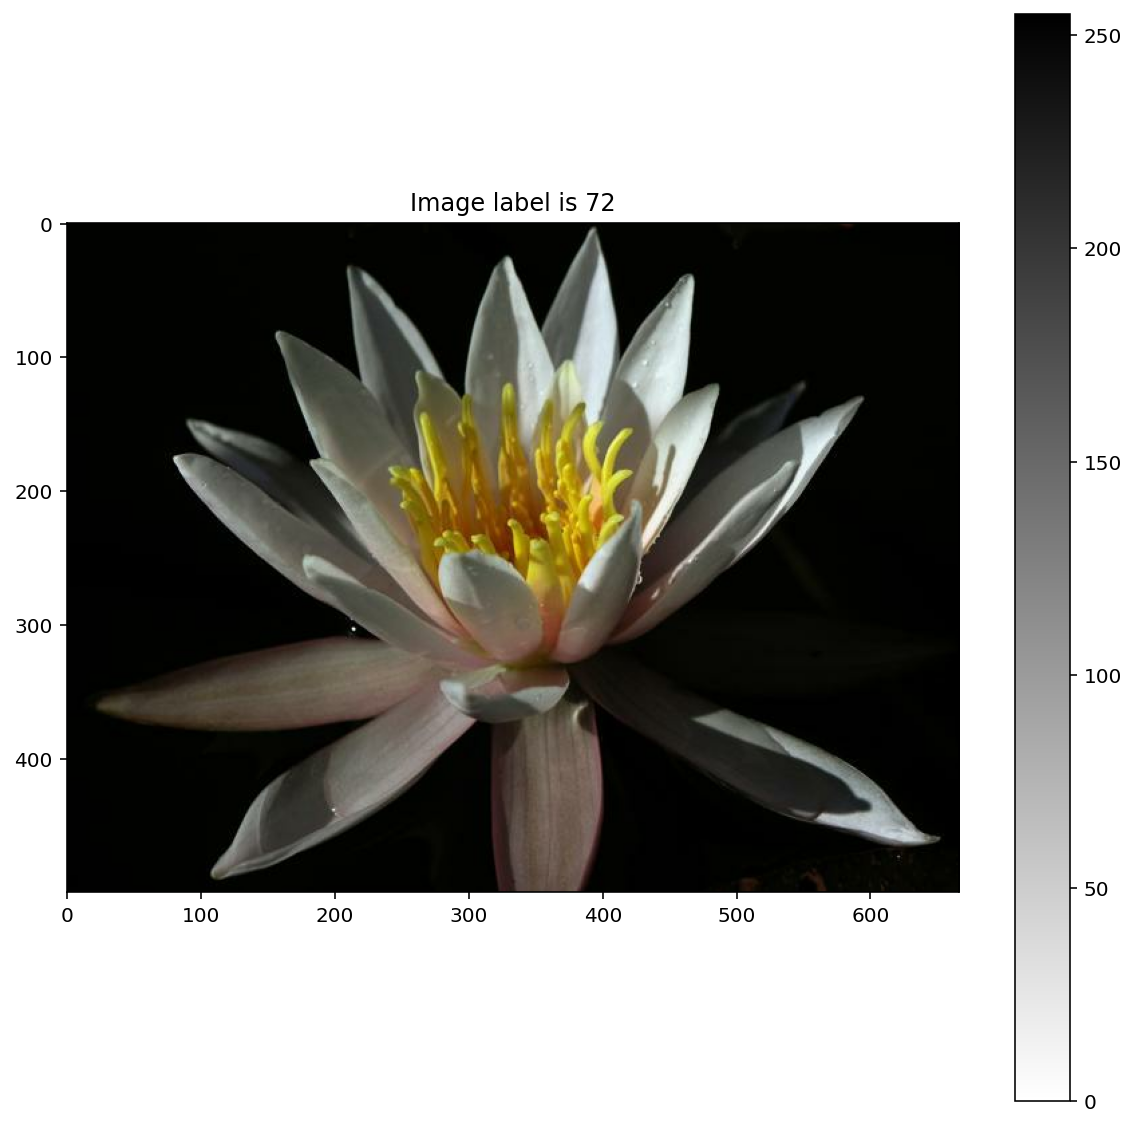

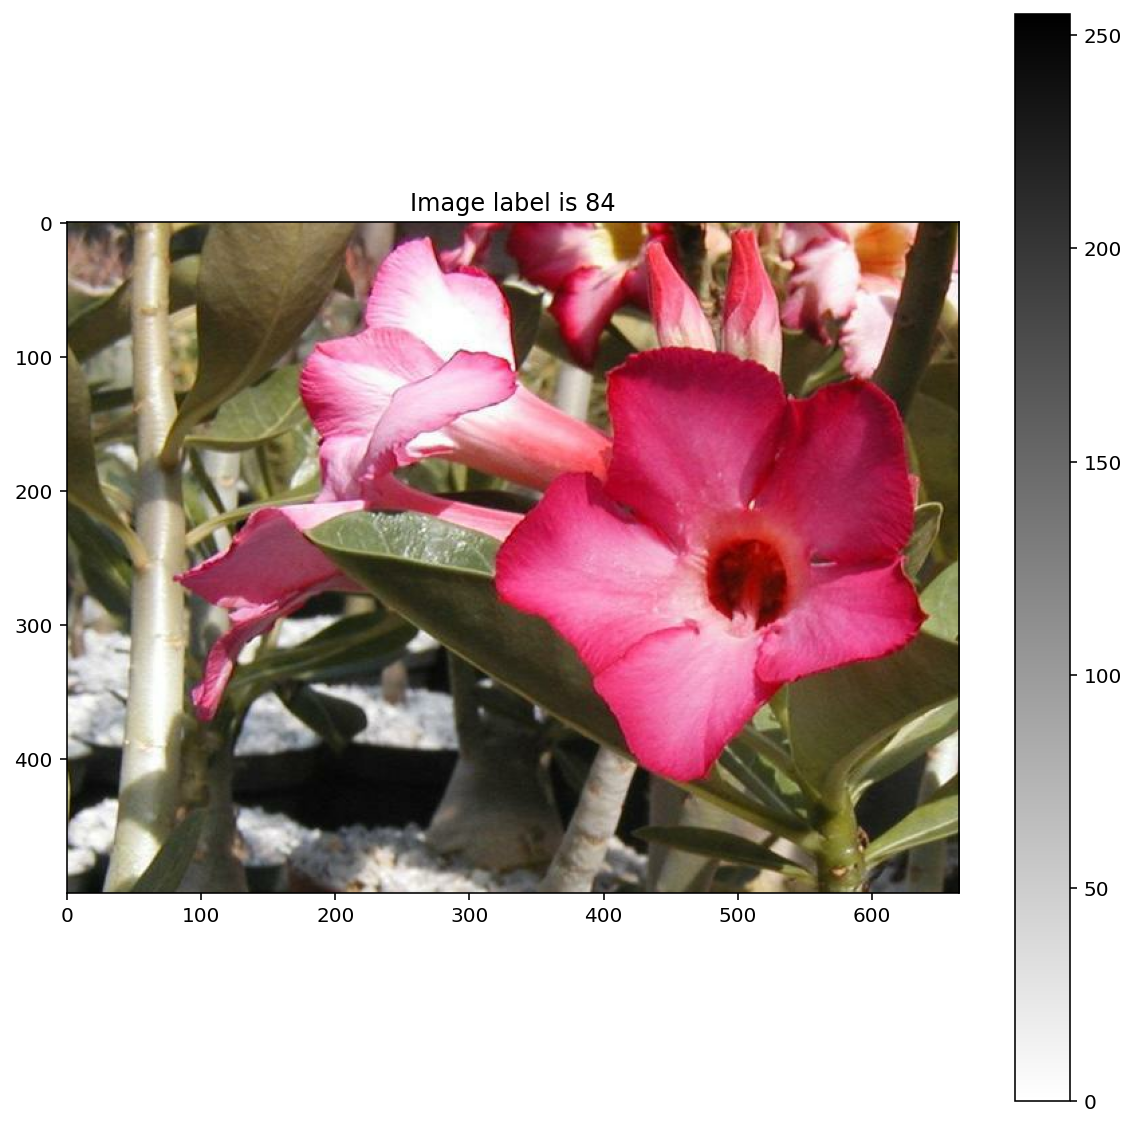

In [7]:
# plot 2 sample images from training_set
for image, label in training_set.take(2):
    image = image.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.title('Image label is {}'.format(label))
    plt.colorbar()
    plt.grid(False)
plt.show()

In [8]:
# load class names from json file

from json import load

file = "label_map.json"
with open(file, "r") as f:
    class_names = load(f)
print(class_names)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

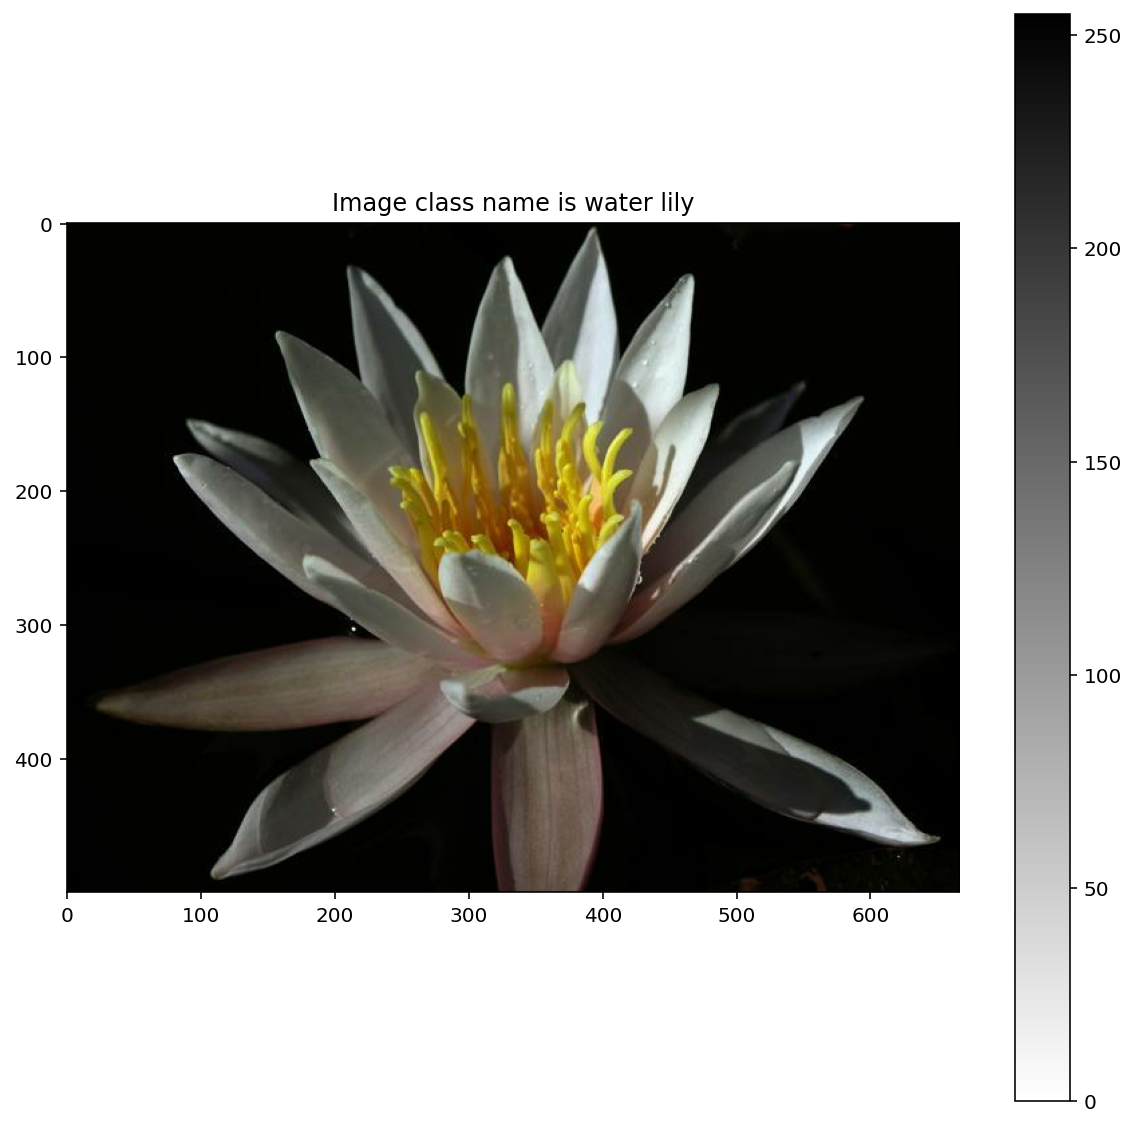

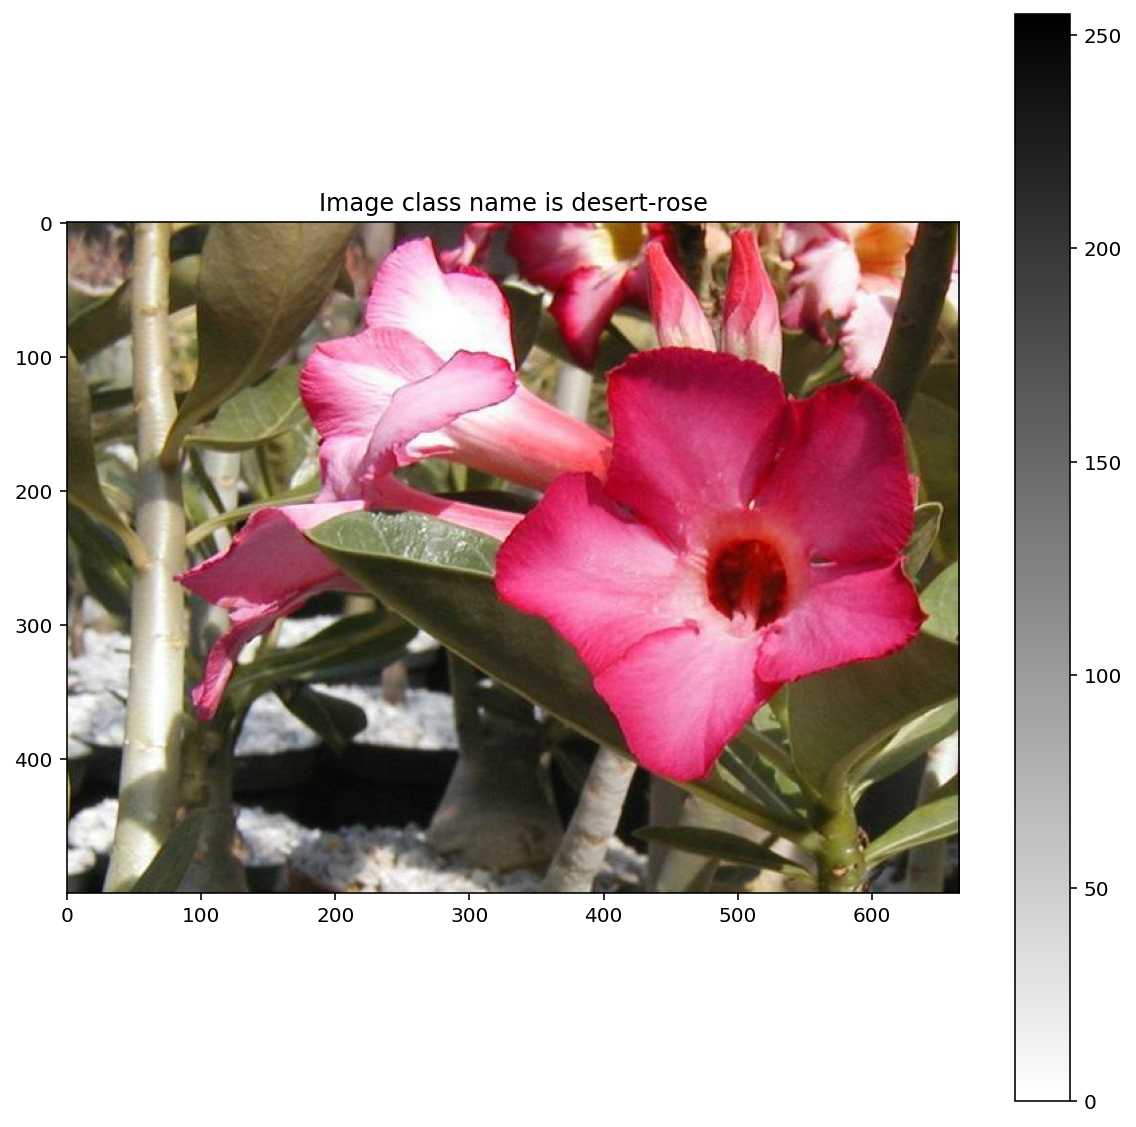

In [9]:
# Visualize two images with its corresponding label names
for image, label in training_set.take(2):
    image = image.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap=plt.cm.binary)
    i = label.numpy()
    class_name = class_names[str(i+1)]
    plt.title('Image class name is {}'.format(class_name))
    plt.colorbar()
    plt.grid(False)
plt.show()

# https://www.tensorflow.org/tutorials/images/classification#visualize_the_data

In [10]:
# build a pipeline
batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


#training_batches = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
training_batches = training_set.cache().shuffle(dataset_info.splits['train'].num_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

# https://r906364c929986xjupyterwbvx9owe.udacity-student-workspaces.com/notebooks/Part_8_Transfer_Learning_(Solution).ipynb

In [11]:
# load pre-trained model from https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub to apply transfer learning
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

# Attach classification head
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
# train the pre-trained model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub#train_the_model
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy 
# https://r906364c929986xjupyterwbvx9owe.udacity-student-workspaces.com/notebooks/Part_7_Loading_Image_Data_(Solution).ipynb

In [13]:
# setup an early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 20
history = model.fit(training_batches,
                    epochs=epochs,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 32s 1s/step - loss: 4.3222 - accuracy: 0.1078 - val_loss: 3.1827 - val_accuracy: 0.3373
Epoch 2/20
32/32 [==============================] - 32s 1s/step - loss: 2.1202 - accuracy: 0.6647 - val_loss: 2.0754 - val_accuracy: 0.6324
Epoch 3/20
32/32 [==============================] - 30s 952ms/step - loss: 1.1244 - accuracy: 0.9000 - val_loss: 1.5820 - val_accuracy: 0.7029
Epoch 4/20
32/32 [==============================] - 30s 946ms/step - loss: 0.6816 - accuracy: 0.9559 - val_loss: 1.3380 - val_accuracy: 0.7373
Epoch 5/20
32/32 [==============================] - 32s 1000ms/step - loss: 0.4541 - accuracy: 0.9794 - val_loss: 1.1885 - val_accuracy: 0.7627
Epoch 6/20
32/32 [==============================] - 31s 979ms/step - loss: 0.3214 - accuracy: 0.9941 - val_loss: 1.0975 - val_accuracy: 0.7755
Epoch 7/20
32/32 [==============================] - 31s 970ms/step - loss: 0.2384 - accuracy: 0.9980 - val_loss: 1.0286 - val_accuracy: 0.7794
Epoc

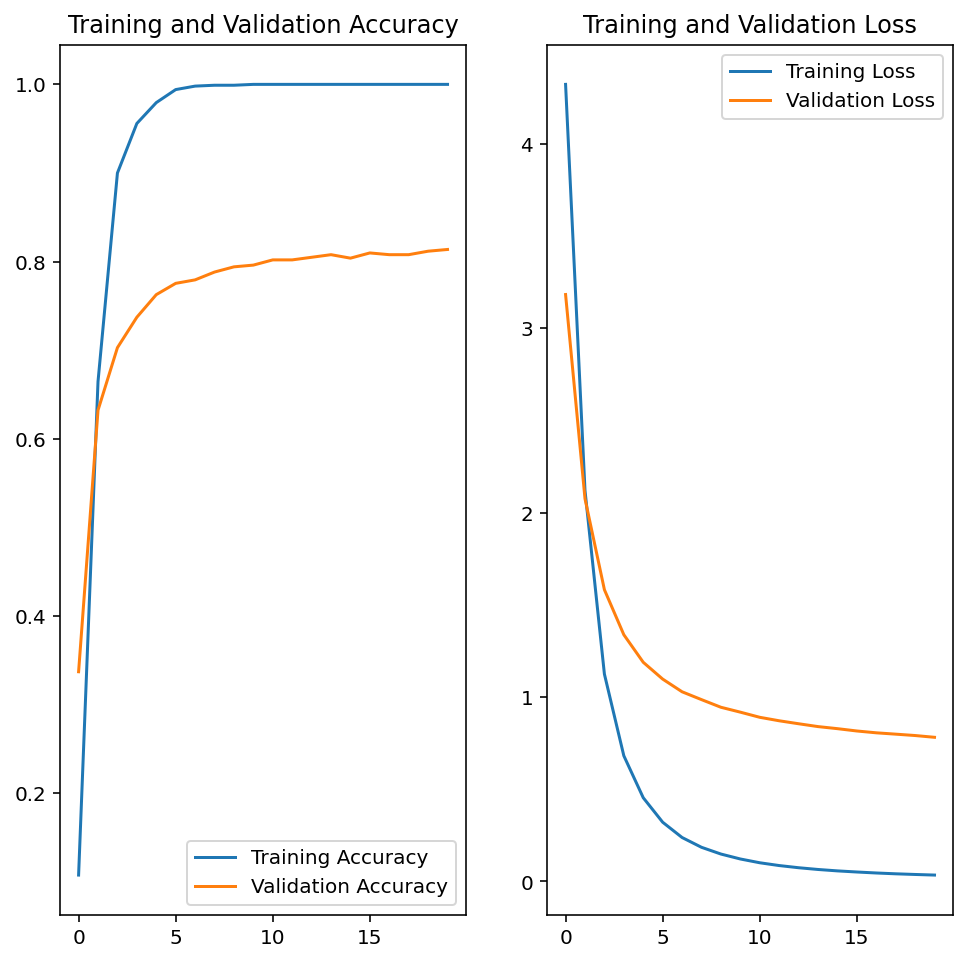

In [14]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# https://www.tensorflow.org/tutorials/images/classification?hl=zh_cn#visualize_training_results

In [15]:
# model evaluation: accuracy values

test_results = model.evaluate(testing_batches, verbose=2)

print('\nTest accuracy:', test_results)

# https://www.tensorflow.org/tutorials/keras/classification#evaluate_accuracy

193/193 - 99s - loss: 0.9086 - accuracy: 0.7795

Test accuracy: [0.9085907340049744, 0.7794763445854187]


In [16]:
# saving the model
model_name = "./my_model.h5"
print('Saved model name is %s'%(model_name))

model.save(model_name)

# https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model

Saved model name is ./my_model.h5


In [17]:
# re-load the saved model
reloaded = tf.keras.models.load_model(
    model_name, 
    custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


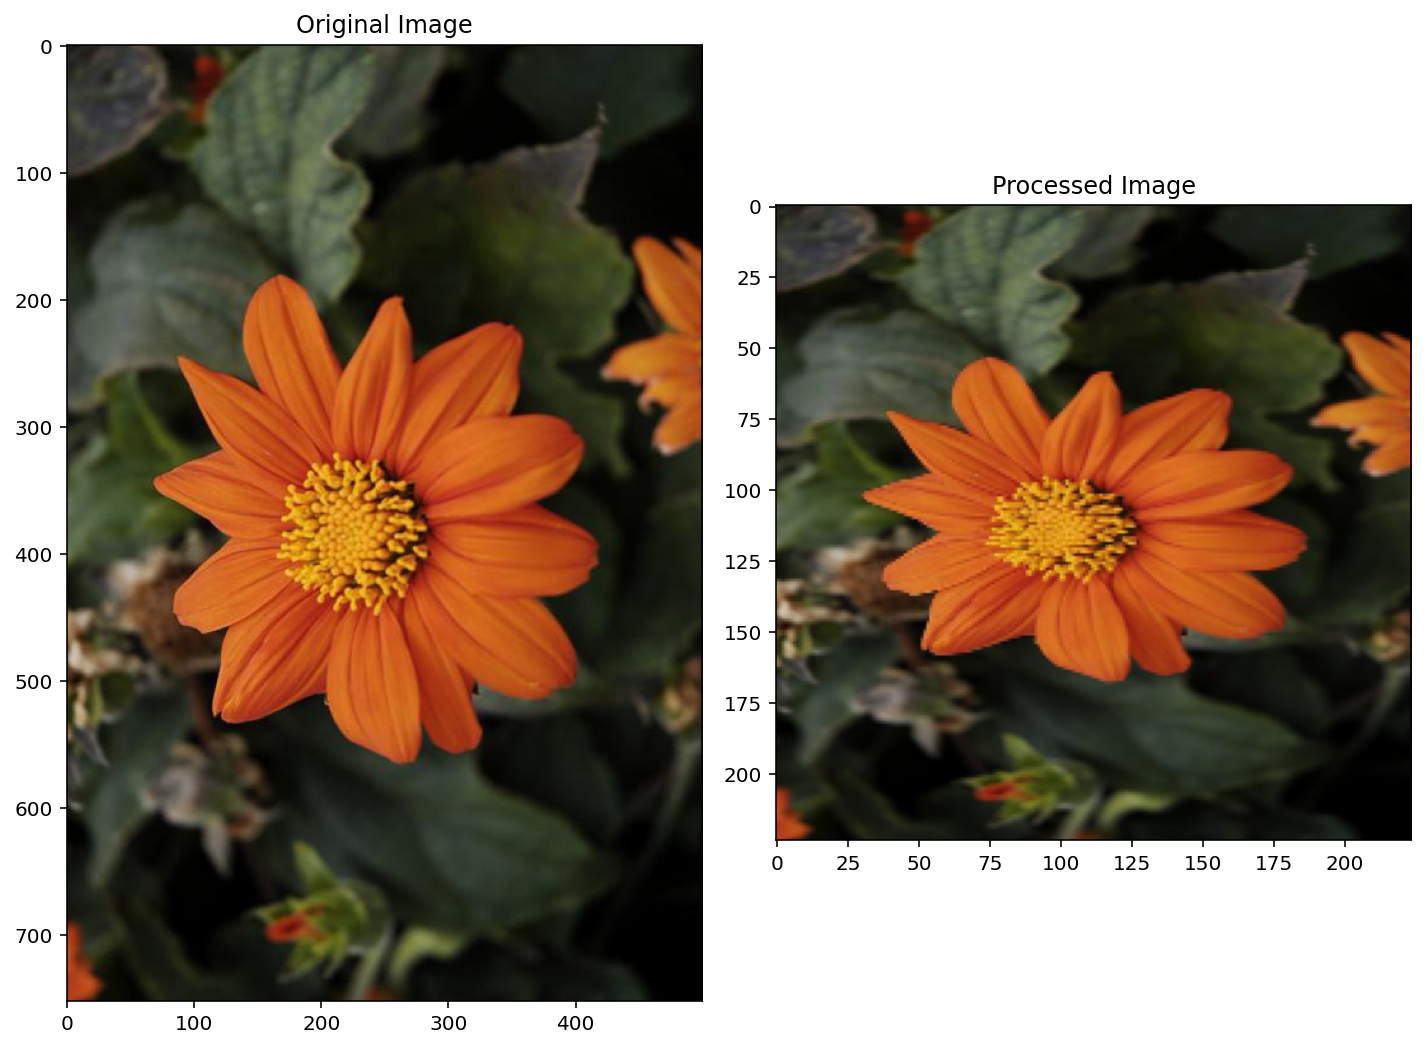

In [60]:
# image pre-processing function
def process_image(img):
    return tf.image.resize(np.squeeze(img), (image_size, image_size))/255.0

# https://classroom.udacity.com/nanodegrees/nd230-mena-connect/parts/12884104-dd4d-483d-ae0d-04c4e21249ef/modules/143301d4-8db5-42e3-94b4-afd7f163cc29/lessons/7142ed9f-8074-4c47-bb1f-7a6e58089a69/concepts/8255fc9c-677f-4910-a109-582d276f2df9
from PIL import Image

image_path = './test_images/orange_dahlia.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [102]:
# predict function

def predict(image_path, model, top_k):
    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    expanded_image = np.expand_dims(processed_test_image, axis=0)
    prediction = model.predict(expanded_image)
    values, indices = tf.math.top_k(input=prediction, k=top_k)
    probs = values.numpy()[0]
    classes = indices.numpy()[0]
    return probs, classes, processed_test_image

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img

In [56]:
def predict(image_path, model, top_k=5):
    image = Image.open(image_path)
    image = np.asarray(image)
    image = process_image(image)
    expanded_image = np.expand_dims(image, axis=0)
    prob_preds = reloaded.predict(expanded_image)
    values, indices = tf.math.top_k(input=prob_preds, k=top_k)
    probs = values.numpy()
    classes = indices.numpy()
    return probs, classes, image

Propabilties: [0.545087   0.1696716  0.07724987 0.0338933  0.02759278]
Classes Keys: [58  4 99 65 70]
Classes Values:
- orange dahlia
- english marigold
- blanket flower
- osteospermum
- gazania


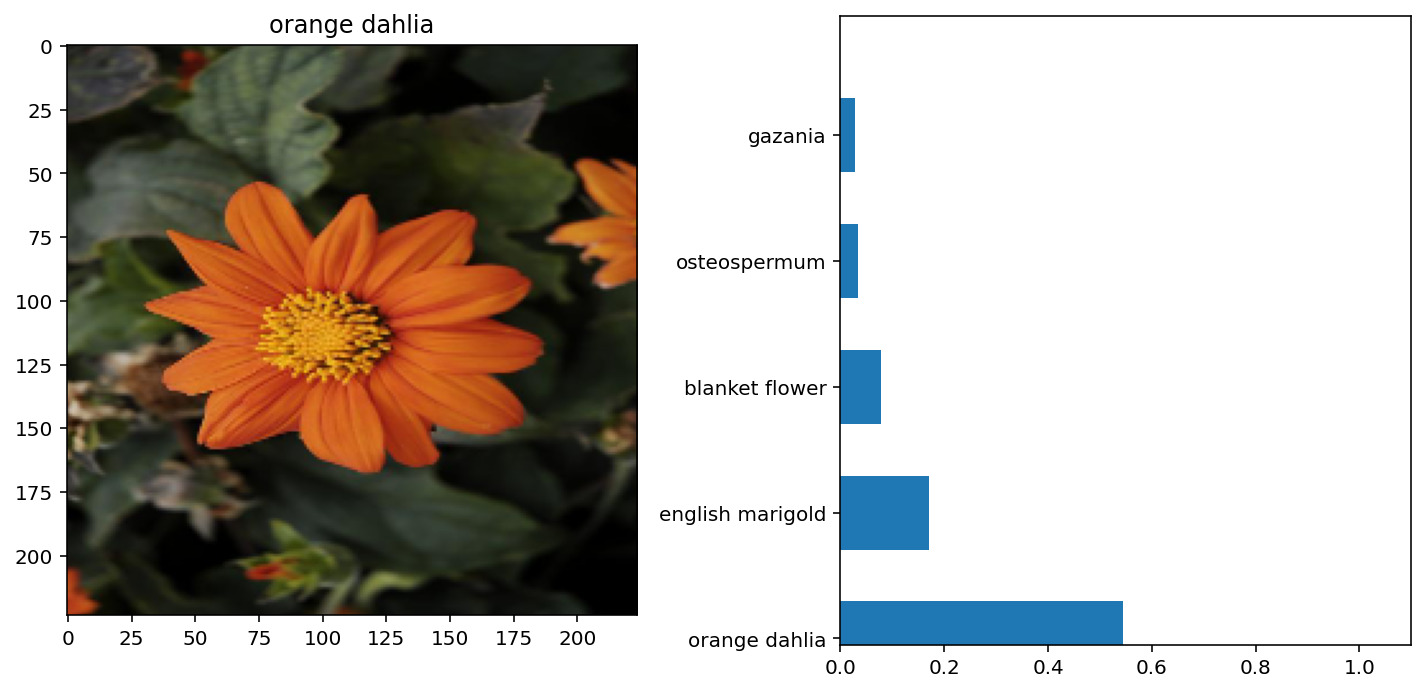

Propabilties: [0.9472521  0.02087644 0.00991178 0.00223058 0.00185573]
Classes Keys: [60 23 45 38 14]
Classes Values:
- cautleya spicata
- red ginger
- wallflower
- siam tulip
- yellow iris


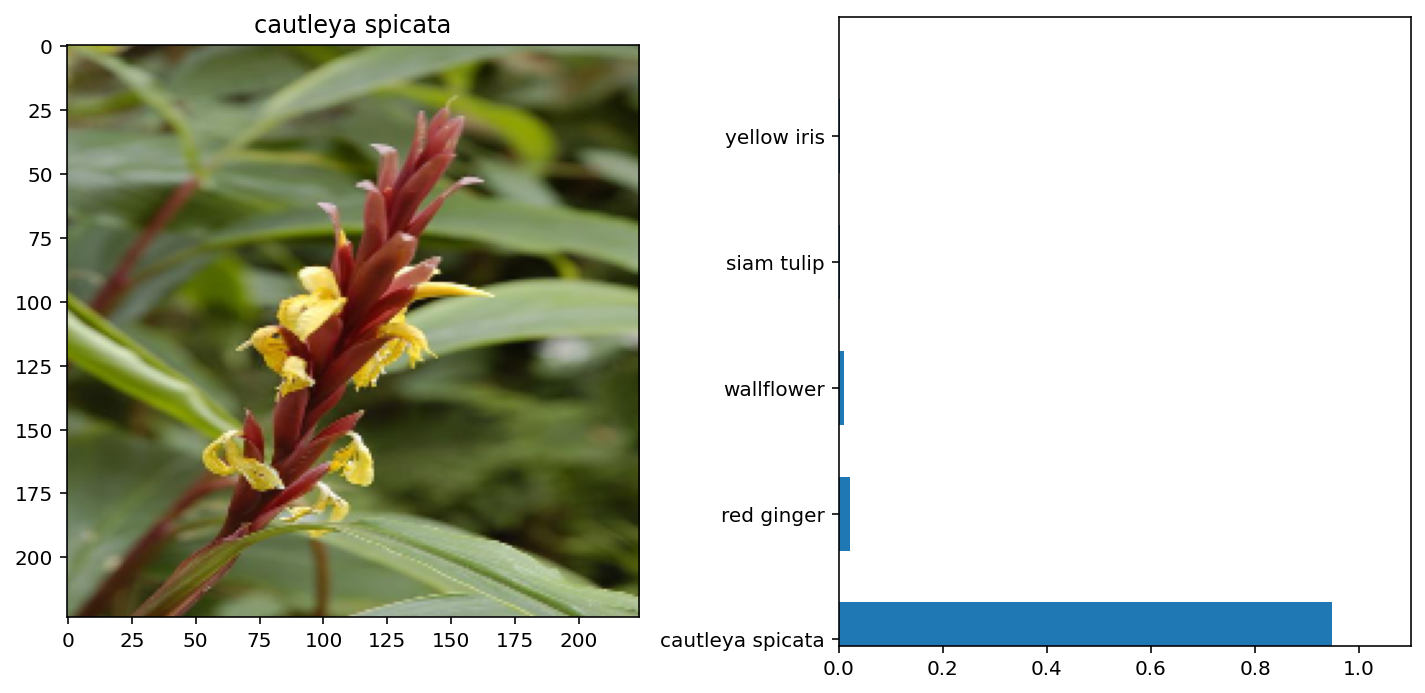

Propabilties: [9.9595731e-01 1.0760205e-03 5.6698540e-04 4.4935662e-04 4.3672571e-04]
Classes Keys: [51 18 33 63 68]
Classes Values:
- wild pansy
- balloon flower
- mexican aster
- silverbush
- windflower


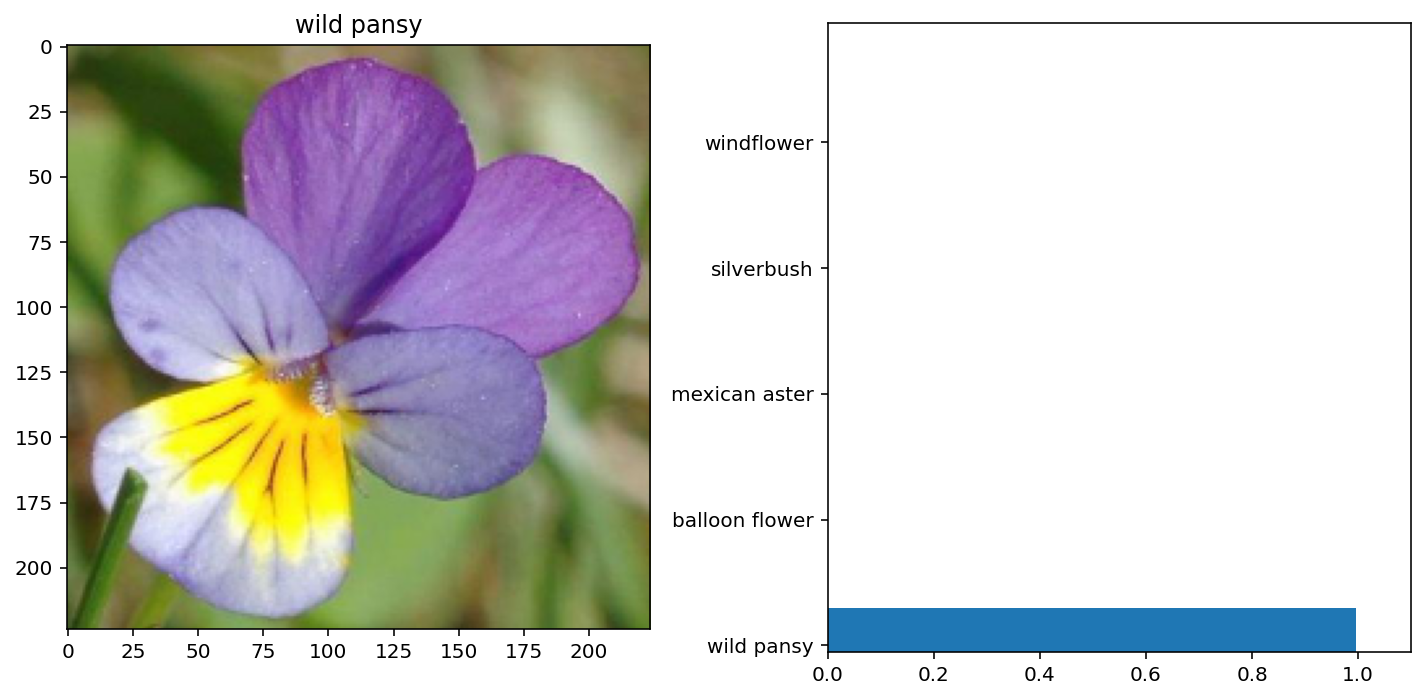

Propabilties: [9.9695373e-01 4.9860281e-04 4.6456725e-04 3.9430958e-04 2.5335667e-04]
Classes Keys: [ 1  6  5 67 96]
Classes Values:
- hard-leaved pocket orchid
- moon orchid
- tiger lily
- bearded iris
- mallow


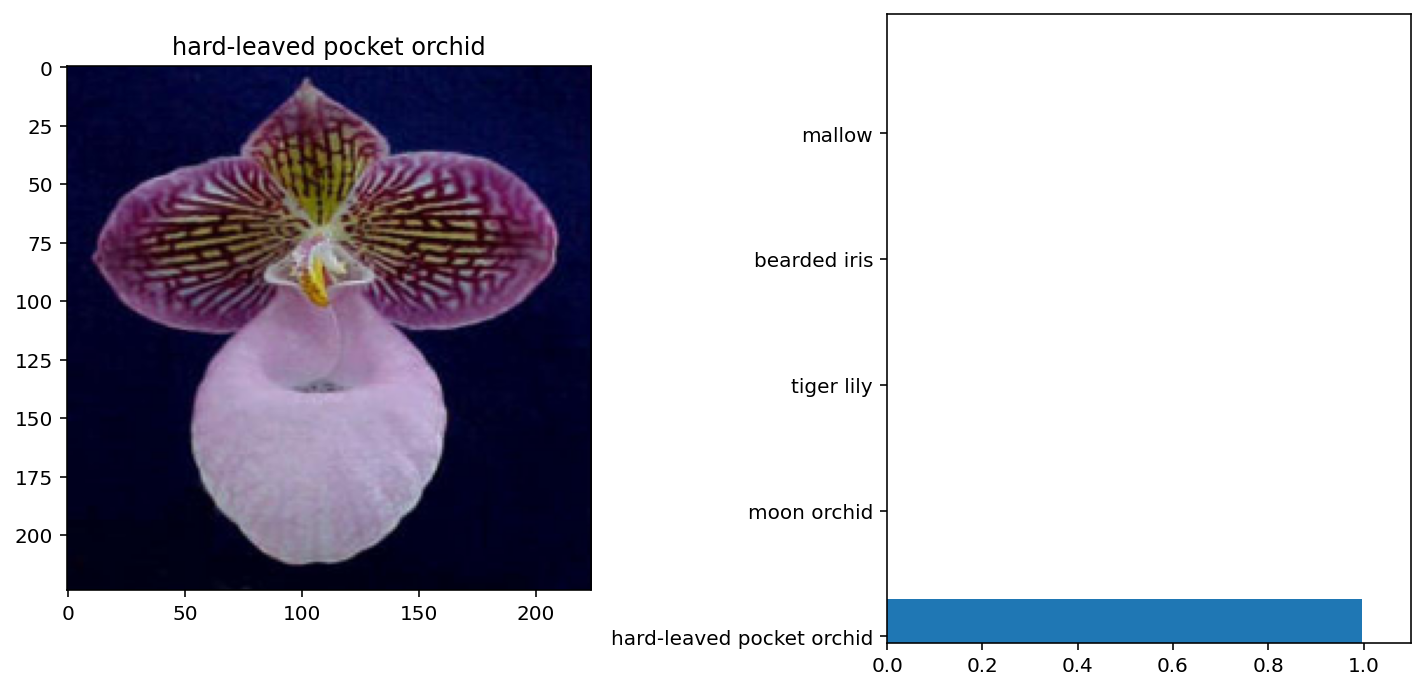

In [132]:
import glob
files = glob.glob('./test_images/*.jpg')
for image_path in files:
    probs, classes, processed_test_image = predict(image_path, model=reloaded, top_k=5)
    print('Propabilties:', probs)
    print('Classes Keys:', classes)
    flower_classes = []
    print("Classes Values:")
    for i in classes:
        print("-",class_names[str(i+1)])
        flower_classes.append(class_names[str(i+1)])
    fig, (ax1, ax2) = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
    ax1.imshow(processed_test_image)
    ax1.set_title(flower_classes[0])
    #ax2.barh(classes, probs)
    ax2.barh(np.arange(1,103,102/5), probs, 12)
    ax2.set_xticks(np.arange(0,1.1,0.2))
    ax2.set_xlim(0, 1.1)
    ax2.set_yticklabels(flower_classes)
    ax2.set_yticks(np.arange(1,103,102/5))
    ax2.set_ylim(0, 102)
    plt.tight_layout()
    plt.show()

In [143]:
# running code at terminal
!python predict.py -img ./test_images/wild_pansy.jpg -m my_model.h5 --category_names label_map.json -k 5
# Output

Namespace(category_names='label_map.json', image_path='./test_images/wild_pansy.jpg', model='my_model.h5', top_k=5)
image_path: ./test_images/wild_pansy.jpg
model: my_model.h5
top_k: 5
category_names: label_map.json
predict.py, running
2020-10-28 19:19:17.916301: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-10-28 19:19:17.927601: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f91eea75200 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-28 19:19:17.927635: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Propabilties: [51 18 33 63 68]
Classes Keys: tf.Tensor(
[[[0.45448178 0.48193276 0.27016804]
  [0.439